In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import np_utils
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from itertools import chain

from tqdm import tqdm
from gensim.models import fasttext
from gensim.test.utils import datapath
import os, re, csv, math, codecs, pickle, nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# OPEN DATA from pickle files
# x_train, x_test, y_train, y_test
# x = tweets data
# y = tweet labels data

with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)
    
with open('x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)


In [3]:
#get tweets as x 

df_x_train = pd.DataFrame(x_train)
df_x_test = pd.DataFrame(x_test)
#x_train
#x_test

#get max length of sentences

list_len = [len(i) for i in x_train]
index_of_max = np.argmax(np.array(list_len))
max_sentence_len = list_len[index_of_max]

#flatten the x_train for fitting in the model tokenizer
x_train_fit = list(chain.from_iterable(x_train))

#get labels as y
df_ytrain = pd.DataFrame(y_train, columns = ['Label'])
df_ytest = pd.DataFrame(y_test, columns = ['Label'])

mapping = {'Positive': 0, 'Negative': 1, 'Neutral':2}
df_ytrain = df_ytrain.replace({'Label': mapping})
df_ytest = df_ytest.replace({'Label': mapping})

train_y = df_ytrain['Label'].tolist()
test_y = df_ytest['Label'].tolist()

np_train_y = np.asarray(train_y)
np_test_y = np.asarray(test_y)
print(max_sentence_len)

39


In [4]:
# DATA VECTORIZATION


#process tweets before vectorization
x_train_sequences = []
x_test_sequences = []

for i in range(len(x_train)):
    tweet = " ".join(x_train[i])
    x_train_sequences.append(tweet)
    
for i in range(len(x_test)):
    tweet = " ".join(x_test[i])
    x_test_sequences.append(tweet)

tokenizer = Tokenizer(num_words=100000, char_level=False)
tokenizer.fit_on_texts(x_train_fit)

word_seq_train_x = tokenizer.texts_to_sequences(x_train_sequences)
word_seq_test_x = tokenizer.texts_to_sequences(x_test_sequences)

print(x_train_sequences[0])
print(word_seq_train_x[0])

#assign word_index from tokenizer to get the training dictionary 
#to check with the fasttext embeddings lateron
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = keras.preprocessing.sequence.pad_sequences(word_seq_train_x, maxlen=max_sentence_len)
word_seq_test = keras.preprocessing.sequence.pad_sequences(word_seq_test_x, maxlen=max_sentence_len)
print(len(word_seq_train))
print(len(word_seq_test))

mrs reason attend smni first sex offender host nang presidential yun also candidates reason show debate loyalist panel
[1054, 372, 345, 98, 177, 1256, 4272, 1512, 146, 9, 224, 92, 106, 372, 95, 26, 1513, 3232]
dictionary size:  14491
6912
768


In [5]:
# LOAD FASTTEXT CORPUS
ft_model = fasttext.load_facebook_model(datapath("cc.tl.300.bin"))

In [6]:
# INCREMENT FASTTEXT CORPUS
sent1 = x_train
#ft_model.train(sent1, total_examples=len(sent1), epochs=5)
ft_model.build_vocab(sent1, update=True)
ft_model.train(sent1, total_examples=len(sent1), epochs=ft_model.epochs)

(49382, 167544)

In [7]:
# EMBEDDING MATRIX
print('preparing embedding matrix...')
words_not_found = []
nb_words = len(word_index)+1
embedding_matrix = np.zeros((nb_words, 300))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ft_model.wv[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 6


In [20]:
#CNN MODEL
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, 300,
          weights=[embedding_matrix], input_length=max_sentence_len, trainable=False))
model.add(Conv1D(256, 2, padding='same', activation='relu'))
model.add(MaxPooling1D(2,2))
model.add(Conv1D(64, 4, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  #binary label non hate or hate

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 300)           4347600   
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 256)           153856    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 256)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 19, 64)            65600     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 6

In [21]:
model_history = model.fit(word_seq_train, np_train_y, batch_size = 32, epochs = 5, verbose=2, validation_split = 0.1)

Epoch 1/5
195/195 - 3s - loss: 0.9921 - accuracy: 0.4786 - val_loss: 0.8754 - val_accuracy: 0.5621 - 3s/epoch - 15ms/step
Epoch 2/5
195/195 - 2s - loss: 0.8329 - accuracy: 0.6055 - val_loss: 0.8193 - val_accuracy: 0.6084 - 2s/epoch - 13ms/step
Epoch 3/5
195/195 - 2s - loss: 0.7689 - accuracy: 0.6444 - val_loss: 0.7798 - val_accuracy: 0.6228 - 2s/epoch - 12ms/step
Epoch 4/5
195/195 - 2s - loss: 0.7096 - accuracy: 0.6826 - val_loss: 0.7413 - val_accuracy: 0.6561 - 2s/epoch - 13ms/step
Epoch 5/5
195/195 - 2s - loss: 0.6602 - accuracy: 0.7034 - val_loss: 0.7258 - val_accuracy: 0.6546 - 2s/epoch - 12ms/step


In [22]:
model.save('fasttextcnn.h5')

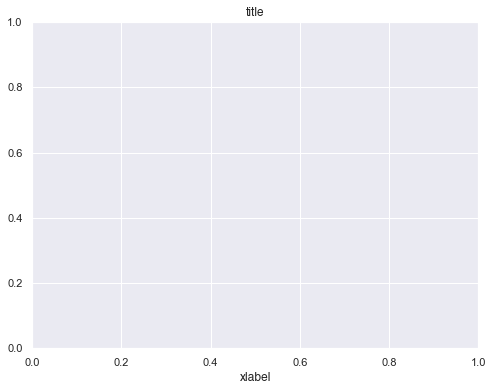

In [23]:
#plot configuration
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber]

csfont = {'fontname':'Helvetica'}
hfont = {'fontname':'Helvetica'}

plt.title('title',**csfont)
plt.xlabel('xlabel', **hfont)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

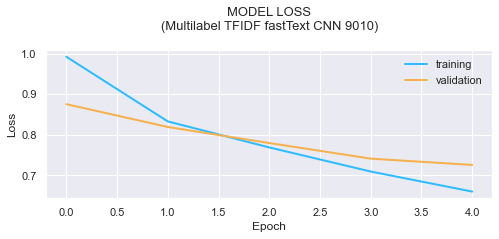

In [24]:
# plot loss during training
plt.subplot(212)
plt.title('MODEL LOSS\n(Multilabel TFIDF fastText CNN 9010)\n', fontsize = 13)
plt.plot(model_history.history['loss'], label='training', linewidth=2)
plt.plot(model_history.history['val_loss'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

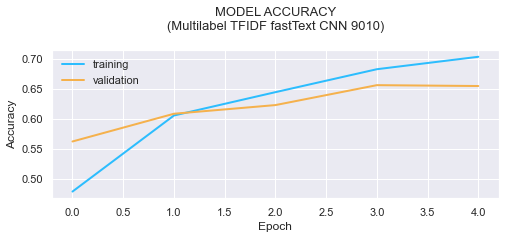

In [25]:
# plot accuracy during training
plt.subplot(212)
plt.title('MODEL ACCURACY\n(Multilabel TFIDF fastText CNN 9010)\n', fontsize = 13)
plt.plot(model_history.history['accuracy'], label='training', linewidth=2)
plt.plot(model_history.history['val_accuracy'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [26]:
ytrain_result = model.predict(word_seq_train)

216/216 [==============================] - 1s 5ms/step


In [27]:
ytest_result = model.predict(word_seq_test)
print(ytest_result)

24/24 [==============================] - 0s 5ms/step
[[0.5762035  0.29427385 0.1295226 ]
 [0.3053807  0.38222334 0.31239596]
 [0.00845724 0.8512238  0.14031896]
 ...
 [0.26705867 0.03455628 0.69838506]
 [0.12612192 0.01312822 0.86074984]
 [0.42157605 0.25493792 0.32348606]]


In [28]:
##### Step 7 - Model Performance Summary
# Predict class labels on training data
pred_labels_train = model.predict(word_seq_train)
# Predict class labels on a test data
pred_labels_test = model.predict(word_seq_test)

#print(pred_labels_train)
pred_labels_train_1 = []

pred_labels_test_1 = []

pred_labels_test_y = []

for i in range(len(pred_labels_train)):
    label = np.argmax(pred_labels_train[i])
    pred_labels_train_1.append(label)
    
for i in range(len(pred_labels_test)):
    label = np.argmax(pred_labels_test[i]) 
    pred_labels_test_1.append(label)
    pred_labels_test_y.append(pred_labels_test[i][label])
    
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('---------- Evaluation on Training Data ----------')
print(classification_report(np_train_y, pred_labels_train_1, digits = 4))
print("")

print('---------- Evaluation on Test Data ----------')
print(classification_report(np_test_y, pred_labels_test_1, digits = 4))
print("")

24/24 [==============================] - 0s 5ms/step

-------------------- Model Summary --------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 300)           4347600   
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 256)           153856    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 256)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 19, 64)            65600     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
          

[[140  23  81]
 [ 13 186  42]
 [ 66  42 175]]


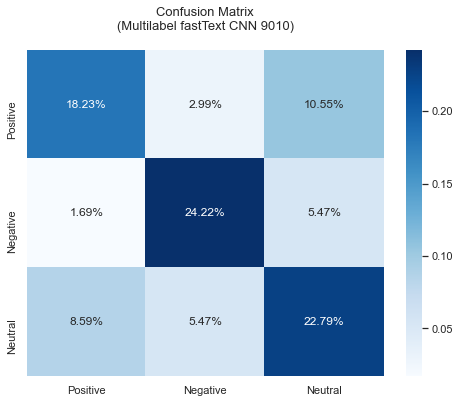

In [32]:
cf_matrix = confusion_matrix(np_test_y, pred_labels_test_1)
print(cf_matrix)

sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels = ['Positive', 'Negative', 'Neutral'], yticklabels = ['Positive', 'Negative', 'Neutral'],
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix\n(Multilabel fastText CNN 9010)\n', fontsize = 13)
plt.show()

In [33]:
test_results = pd.DataFrame(list(zip(x_test,pred_labels_test_1, pred_labels_test_y)), columns = ['Tweet','Prediction', 'Prediction Value'])
test_results 

,Tweet,Prediction,Prediction Value
0,"[bbmsara, win, rin, inday, sara, win]",0,0.576204
1,"[inaniyo, pag, di, si, nanalo, itatakwil, pami...",1,0.382223
2,"[presidential, aspirant, manila, fired, shots,...",1,0.851224
3,"[gobyernong, tapat, angat, buhay, si, yancy, i...",0,0.979453
4,"[oras, kandidatong, tunay, magdadala, pagbabag...",0,0.657396
...,...,...,...
763,"[presidente, bise, presidente, kiko, pangilina...",0,0.780514
764,"[mt, mayon, showed, seems, like, looking, vp, ...",0,0.587240
765,[president],2,0.698385
766,"[unforgettable, rally, experience, agusan, del...",2,0.860750


In [34]:
#Saving labels to be used on other files
true_labels = open('true_labels.pkl', 'wb')
pickle.dump(np_test_y,true_labels)
true_labels.close()

predicted_labels = open('fastTextCNN_predicted_labels.pkl', 'wb')
pickle.dump(pred_labels_test_1,predicted_labels)
predicted_labels.close()

fastTextCNN_test_results = open('fastTextCNN_test_results.pkl', 'wb')
pickle.dump(test_results,fastTextCNN_test_results)
fastTextCNN_test_results.close()